## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import copy
from tqdm import tqdm
from scipy.ndimage.interpolation import shift

plt.rcParams['figure.figsize'] = [10, 8]
colours = ['blue', 'red', 'gray', 'black']


# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

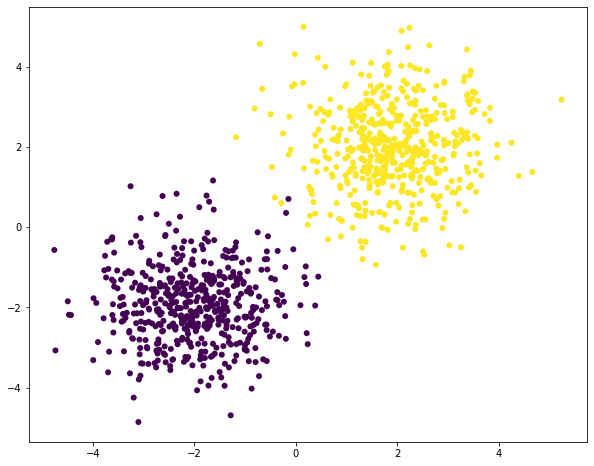

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N, 2) + np.array([2, 2])
X2 = np.random.randn(N, 2) + np.array([-2, -2])


Y = np.concatenate([np.ones(N),np.zeros(N)])[:, None]
Y = np.hstack([Y, 1 - Y])

X = np.vstack([X1, X2])
plt.scatter(X[:, 0], X[:, 1], c = Y[:, 0], edgecolors = 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

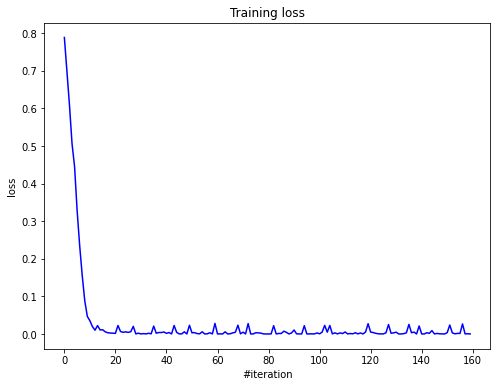

Current loss: 0.000022


In [7]:
loss_history = []
optimizer_state = {}
for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize = (8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)   


# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [8]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [9]:
# Your code goes here. ################################################
def one_hot_encode(n_classes, y):
    y_one_hot = np.zeros((len(y), n_classes), dtype = float)
    y_one_hot[np.arange(len(y)), y.astype(int)[:, 0]] = 1.
    return y_one_hot
def one_hot_decode(y_one_hot):
    return y_one_hot.argmax(axis = 1)[:, None]
    
n_classes = len(np.unique(y_test))
input_dim = X_train[0].shape[0] * X_train[0].shape[1] * 1
print("Input dim is: ", input_dim)
print("We have {} classes over here".format(n_classes))
y_train_one_hot = one_hot_encode(n_classes, y_train[:, None])
y_test_one_hot = one_hot_encode(n_classes, y_test[:, None])


Input dim is:  784
We have 10 classes over here


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [12]:
# Your code goes here. ################################################

# Here defned setup configuration
# -------------------------------

# configuration of the net
net_config = {
    "input_dim": input_dim,
    "hidden_dim": 128,
    "n_layers": 3,
    "use_batchnorm": False,
    "n_classes": 10,
    "dropout_rate": 0.,
    "weight_decay": 0.}
#training details
batch_size = 128
# ------------------------------

# function, not class, sorry -- creates us net with given configuration
def create_net(config = net_config, activation = 'ReLU', 
               param = {"alpha": .9, 'slope': 0.5}):
    
    activations = {"ReLU": ReLU(),
        "ELU": ELU(alpha = param['alpha']),
        "LeakyReLU": LeakyReLU(slope = param['slope']),
        "SoftPlus": SoftPlus()}
    
    if activation not in activations: 
        raise ValueError("No such activation: choose between" + str(list(activations.keys())))
    else: Activation = activations[activation] 
        
    net = Sequential()
    hidden_dim = copy.copy(config["hidden_dim"])
    prev_layer_input_dim = copy.copy(config['input_dim'])
    
    for layer in range(config["n_layers"]):
        net.add(Linear(prev_layer_input_dim, hidden_dim))
        
        
        if (config['use_batchnorm']):
            net.add(BatchNormalization(0.9))
            net.add(ChannelwiseScaling(hidden_dim))
        net.add(Dropout(p = config["dropout_rate"]))    
        net.add(Activation)
        prev_layer_input_dim = hidden_dim
        
    net.add(Linear(prev_layer_input_dim, config["n_classes"]))
    net.add(LogSoftMax())
    return net

def evaluate(net, X_train, y_train, X_val, y_val, X_test, y_test, n_epochs: int, batch_size: int,
                    loss_fn, optimizer, plot_args):
    #optimizers configuration
    adam_config = {'learning_rate': .8 * 1e-3, 'beta1': 0.9, 'beta2': 0.999, 'epsilon': 1e-8}
    sgd_config = {'learning_rate' : 1e-1, 'momentum': 0.9}

    # train loop
    def train_model(net, X_train, y_train, X_val, y_val, n_epochs: int, batch_size: int,
                    loss_fn, optimizer, debug = False):
        train_loss_history = []
        val_loss_history = []
        val_accuracy = []
        optimizers = {"SGD": sgd_momentum,
                     "Adam": adam_optimizer}

        if optimizer not in optimizers: 
            raise ValueError("No such optimizer: choose between" + str(list(optimizers.keys())))
        else: 
            optimizer_ = optimizers[optimizer]
            if optimizer == "Adam": optimizer_config = adam_config
            if optimizer == "SGD": optimizer_config = sgd_config

        optimizer_state = {}
        
        for epoch in tqdm(range(n_epochs), total = n_epochs):
            ep_train_loss_history = []
            ep_val_loss_history = []
            ep_val_accuracy = []
            start_time = time()
            
            _ = net.train()
            for X_batch, y_batch in get_batches((X_train, y_train), batch_size):
                net.zeroGradParameters()
                
                predictions = net.forward(X_batch.reshape((-1, input_dim)))
                loss = loss_fn.forward(predictions, y_batch) 
                + .5 * net_config['weight_decay'] * np.sum([np.sum(np.array(p) ** 2) for p in
                                                           np.array(net.getParameters()[0][0])]) 
                

                dL = loss_fn.backward(predictions, y_batch) \
                                    + net_config['weight_decay'] * np.sum([np.sum(p) for p in
                                                                    net.getParameters()[0][0]])
                net.backward(X_batch.reshape((-1, input_dim)), dL)

                optimizer_(net.getParameters(), 
                         net.getGradParameters(), 
                         optimizer_config,
                         optimizer_state)
                            
                ep_train_loss_history.append(loss)
                
            _ = net.evaluate()    
            for X_batch, y_batch in get_batches((X_val, y_val), batch_size):
                
                predictions = net.forward(X_batch.reshape((-1, input_dim)))
                loss = loss_fn.forward(predictions, y_batch) \
                 + .5 * net_config['weight_decay'] * np.sum([np.sum(np.array(p) ** 2) for p in
                                                           np.array(net.getParameters()[0][0])]) 
                
                y_pred = one_hot_decode(predictions)
                y_batch = one_hot_decode(y_batch)
                
                ep_val_loss_history.append(loss)
                ep_val_accuracy.append(np.sum(y_batch == y_pred)/ len(y_batch))

            val_accuracy.append(np.mean(ep_val_accuracy))
            val_loss_history.append(np.mean(ep_val_loss_history))    
            train_loss_history.append(np.mean(ep_train_loss_history))
            
            if debug: 
                print("Epoch {} took {} s".format(epoch, round(time() - start_time, 3)))
                print("\t Train loss: ", train_loss_history[-1])
                print("\t Validation loss: ", val_loss_history[-1])
                print("\t Validation accuracy: ", val_accuracy[-1])
        return train_loss_history, val_loss_history, val_accuracy

    #test loop
    def test_model(net, X_est, y_test, batch_size,
                    loss_fn, optimizer, debug = False):
        loss_history = []
        accuracy = []
        _ = net.evaluate()

        start_time = time()

        for X_batch, y_batch in get_batches((X_test, y_test), batch_size):

            predictions = net.forward(X_batch.reshape((-1, input_dim)))
            loss = loss_fn.forward(predictions, y_batch)

            y_pred = one_hot_decode(predictions)
            y_batch = one_hot_decode(y_batch)

            loss_history.append(loss)
            accuracy.append(np.sum(y_batch == y_pred)/ len(y_batch))

        if debug: 
            print("Testing took {} s".format(epoch, round(time() - start_time, 3)))

            print("Loss: ", loss_history)
            print("Accuracy: ", accuracy)
        return np.mean(loss_history), np.mean(accuracy)
    
    def visualize(history_list, accuracy_list, plot_args):
        label = plot_args['label']
        if 'linewidth' in plot_args: linewidth = plot_args['linewidth']
        else: linewidth = 1
        
        if 'color' in plot_args: 
            color = plot_args['color']    
            plt.plot(np.arange(1, n_epochs + 1, 1), history_list, label = label, 
                 linewidth = linewidth, color = color)
            
        else: plt.plot(np.arange(1, n_epochs + 1, 1), history_list, label = label, 
                 linewidth = linewidth)
            
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.grid(True)
        plt.yscale("log")
        plt.legend(loc = 'best')
        print("Accuracy on test is {} \n".format(round(accuracy, 3)))
        
    print("---------------------------")    
    print("___TRAINING AND VALIDATIND____")
    
    y_train_one_hot = one_hot_encode(n_classes, y_train[:, None])
    y_val_one_hot = one_hot_encode(n_classes, y_val[:, None])
    y_test_one_hot = one_hot_encode(n_classes, y_test[:, None])
    
    train_loss_history, val_loss_history, val_accuracy = train_model(net, \
                            X_train, y_train_one_hot, X_val, y_val_one_hot, \
                            n_epochs, batch_size, loss_fn, optimizer)
    
    print("___TESTING____")
    print("---------------------------")
        
    test_loss, accuracy = test_model(net, X_test, y_test_one_hot, batch_size,
                                     loss_fn, optimizer)     
    _ = visualize(val_loss_history, accuracy, plot_args)
    

  0%|          | 0/12 [00:00<?, ?it/s]

Testing activation func ReLU
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 12/12 [12:00<00:00, 60.04s/it]


___TESTING____
---------------------------


  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy on test is 0.97 

Testing activation func ELU
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 12/12 [11:22<00:00, 56.88s/it]


___TESTING____
---------------------------


  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy on test is 0.966 

Testing activation func LeakyReLU
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 12/12 [10:19<00:00, 51.65s/it]


___TESTING____
---------------------------


  0%|          | 0/12 [00:00<?, ?it/s]

Accuracy on test is 0.957 

Testing activation func SoftPlus
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 12/12 [10:38<00:00, 53.17s/it]


___TESTING____
---------------------------
Accuracy on test is 0.966 



Text(0.5, 1.0, 'Different activation fucntions')

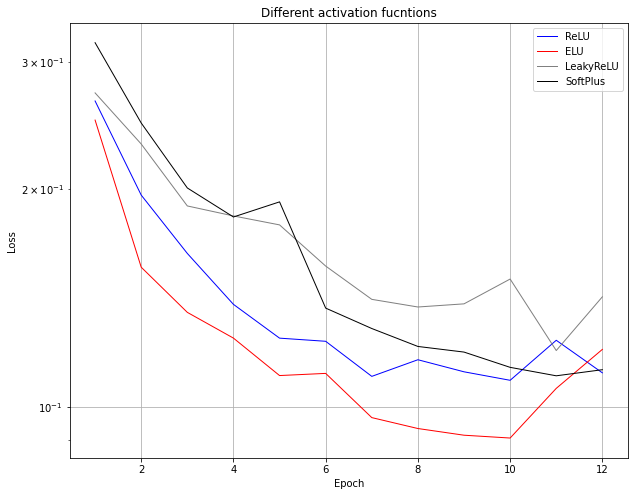

In [11]:
activations = ["ReLU", "ELU", "LeakyReLU", "SoftPlus"]
n_epochs = 12
for i, activation in enumerate(activations):
    print("Testing activation func {}".format(activation))
    Net = create_net(activation = activation)
    _ = evaluate(Net, X_train, y_train, X_val, y_val, X_test, y_test,
                 n_epochs, batch_size, ClassNLLCriterion(), "Adam", 
                 {'label': activation, 'color': colours[i]})
    
plt.title("Different activation fucntions")

How we can see, `ELU` and `ReLU` activations are better than others.

  0%|          | 0/10 [00:00<?, ?it/s]

Testing activation func ReLU with BN = False
---------------------------
___TRAINING AND VALIDATIND____


  0%|          | 0/10 [00:00<?, ?it/s]

___TESTING____
---------------------------
Accuracy on test is 0.972 

Testing activation func ReLU with BN = True
---------------------------
___TRAINING AND VALIDATIND____


  0%|          | 0/10 [00:00<?, ?it/s]

___TESTING____
---------------------------
Accuracy on test is 0.976 

Testing activation func ELU with BN = False
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [09:26<00:00, 56.60s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.972 

Testing activation func ELU with BN = True
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [15:11<00:00, 91.12s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.958 

Testing activation func LeakyReLU with BN = False
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [13:59<00:00, 83.97s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.959 

Testing activation func LeakyReLU with BN = True
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [12:52<00:00, 77.29s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.963 

Testing activation func SoftPlus with BN = False
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [08:21<00:00, 50.18s/it]


___TESTING____
---------------------------
Accuracy on test is 0.962 


  0%|          | 0/10 [00:00<?, ?it/s]


Testing activation func SoftPlus with BN = True
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [08:32<00:00, 51.20s/it]


___TESTING____
---------------------------
Accuracy on test is 0.955 



Text(0.5, 1.0, 'An experiment with BatchNorm')

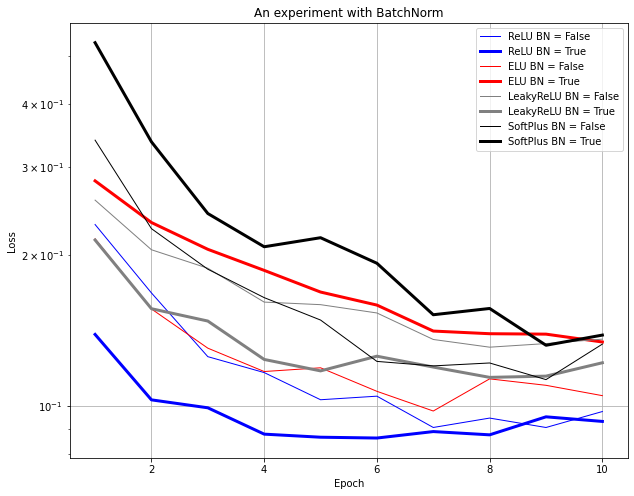

In [24]:
activations = ["ReLU", "ELU", "LeakyReLU", "SoftPlus"]
use_batchnorm = [False, True]
n_epochs = 10
for i, activation in enumerate(activations):
    for flag in use_batchnorm:
        print("Testing activation func {} with BN = {}".format(activation, flag))
        net_config['use_batchnorm'] = flag
        Net = create_net(config = net_config, activation = activation)
        _ = evaluate(Net, X_train, y_train, X_val, y_val, X_test, y_test,
                 n_epochs, batch_size, ClassNLLCriterion(), "Adam", 
                {'linewidth': 2 * flag + 1, 'label': activation + " BN = {}".format(flag),
                'color': colours[i]})
plt.title("An experiment with BatchNorm")

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

`ELU` and `SoftPlus` are too computatitional expensive, they need two more second per epoch in contrast to `ReLU`.

My own opinion of activation functions and batch normalization: on the grah above we can see how different activation funtions react to using `BatchNormalization`: some of them (e.g. `ReLU` and `LeakyReLU`) improved classification metrics but 2 others reacted in bad way. 

To sum up: I will use `ReLU` with `BatchNormalization` in futher



  0%|          | 0/15 [00:00<?, ?it/s]

Testng with the optimizer Adam
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 15/15 [16:09<00:00, 64.64s/it]


___TESTING____
---------------------------


  0%|          | 0/15 [00:00<?, ?it/s]

Accuracy on test is 0.977 

it took 969.896 s
Testng with the optimizer SGD
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 15/15 [14:06<00:00, 56.41s/it]


___TESTING____
---------------------------
Accuracy on test is 0.97 

it took 846.483 s


Text(0.5, 1.0, 'An experiment with optimizers')

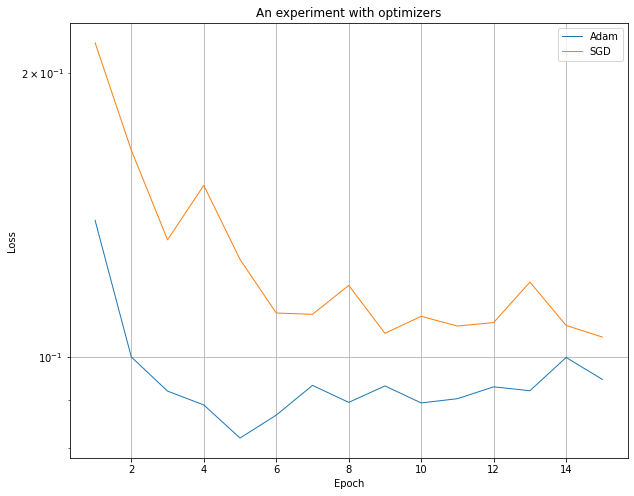

In [12]:
optimizers = ["Adam", "SGD"]
n_epochs = 15
net_config['use_batchnorm'] = True
net_config["dropout_rate"] = 0.

for optimizer in optimizers:
    print("Testng with the optimizer {}".format(optimizer))
    Net = create_net(config = net_config, activation = "ReLU")
    start_time = time()
    _ = evaluate(Net, X_train, y_train, X_val, y_val, X_test, y_test,
                 n_epochs, batch_size, ClassNLLCriterion(), optimizer, {'label': optimizer})
    print("it took {} s".format(round(time() - start_time, 3)))
plt.title("An experiment with optimizers")

Here we can see 2 factors: `Adam` is (default) better optimizer than default `SGD`, `SGD` is more unstable and needs more sophisticated setting of `lr` parameter.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

  0%|          | 0/10 [00:00<?, ?it/s]

Testing parameters decay = 0, dropout = 0
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [10:25<00:00, 62.52s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.974 

it took 625.567 s
Testing parameters decay = 0.1, dropout = 0
---------------------------
___TRAINING AND VALIDATIND____


  0%|          | 0/10 [00:00<?, ?it/s]

___TESTING____
---------------------------
Accuracy on test is 0.944 

it took 580.39 s
Testing parameters decay = 0.5, dropout = 0
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [08:39<00:00, 51.97s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.86 

it took 519.927 s
Testing parameters decay = 0, dropout = 0.15
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [08:48<00:00, 52.80s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.969 

it took 528.23 s
Testing parameters decay = 0.1, dropout = 0.15
---------------------------
___TRAINING AND VALIDATIND____


  0%|          | 0/10 [00:00<?, ?it/s]

___TESTING____
---------------------------
Accuracy on test is 0.323 

it took 653.161 s
Testing parameters decay = 0.5, dropout = 0.15
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [08:44<00:00, 52.50s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.876 

it took 525.228 s
Testing parameters decay = 0, dropout = 0.33
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [09:00<00:00, 54.02s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.96 

it took 540.461 s
Testing parameters decay = 0.1, dropout = 0.33
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [08:50<00:00, 53.07s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.932 

it took 530.937 s
Testing parameters decay = 0.5, dropout = 0.33
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [08:38<00:00, 51.88s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.615 

it took 519.096 s
Testing parameters decay = 0, dropout = 0.5
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [08:33<00:00, 51.40s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.934 

it took 514.25 s
Testing parameters decay = 0.1, dropout = 0.5
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [08:43<00:00, 52.33s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.158 

it took 523.605 s
Testing parameters decay = 0.5, dropout = 0.5
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [09:24<00:00, 56.48s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.14 

it took 564.998 s
Testing parameters decay = 0, dropout = 0.75
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [09:08<00:00, 54.87s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.375 

it took 549.017 s
Testing parameters decay = 0.1, dropout = 0.75
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [08:33<00:00, 51.33s/it]


___TESTING____
---------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on test is 0.098 

it took 513.594 s
Testing parameters decay = 0.5, dropout = 0.75
---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 10/10 [08:50<00:00, 53.04s/it]


___TESTING____
---------------------------
Accuracy on test is 0.097 

it took 530.687 s


Text(0.5, 1.0, 'An experiment')

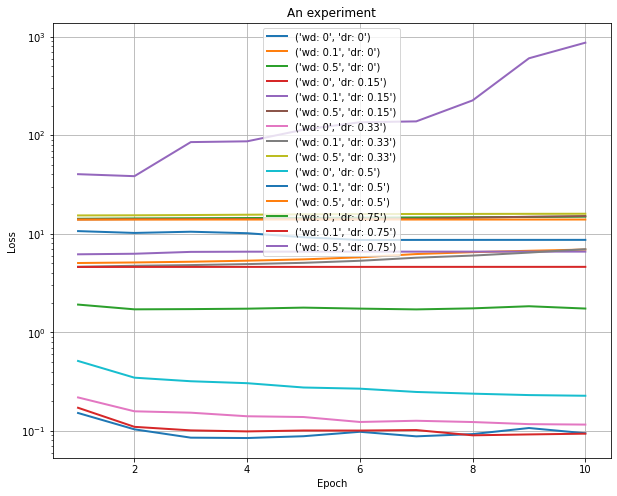

In [14]:
# Your code goes here. ################################################
# Data Augmentation part
def shift_image(image, w, h):
    image = image.reshape((28, 28))
    return shift(image, [h, w], cval = 0, mode = 'constant').reshape([-1])
#no need -- we have enough images -- i wrote this fucntion just to show how to augmente in
#numpy for MYSELF!

weight_decays = [0, 1e-1, .5]
dropout_rates = [0, 0.15, .33, 0.5, 0.75]
optimizer = "Adam"
activation = "ReLU"
net_config['use_batchnorm'] = True
n_epochs = 10

for dropout_rate in dropout_rates:
    for weight_decay in weight_decays:
        print("Testing parameters decay = {}, dropout = {}".format(weight_decay, dropout_rate))
        net_config["dropout_rate"] = dropout_rate
        net_config["weight_decay"] = weight_decay
        
        Net = create_net(config = net_config, activation = "ReLU")
        start_time = time()
        _ = evaluate(Net, X_train, y_train, X_val, y_val, X_test, y_test,
                 n_epochs, batch_size, ClassNLLCriterion(), optimizer, 
                     {'label': ("wd: {}".format(weight_decay), "dr: {}".format(dropout_rate)),
                     'linewidth': 2})
        print("it took {} s".format(round(time() - start_time, 3)))
plt.title("An experiment")

Here we can admit the negative impact of `weight_decay` (I do not know whether is my implementation correct) but as it seems we do not need L2 regularization over here. I asked about the problem of numeriс stability in the course chat but did not get any answer.

Dropout has positive impact on performance of neural network.

Print here your accuracy on test set. It should be around 90%.

`accuracy = 0.972`

  0%|          | 0/20 [00:00<?, ?it/s]

---------------------------
___TRAINING AND VALIDATIND____


100%|██████████| 20/20 [21:32<00:00, 64.63s/it]


___TESTING____
---------------------------
Accuracy on test is 0.972 

it took 1292.982 s


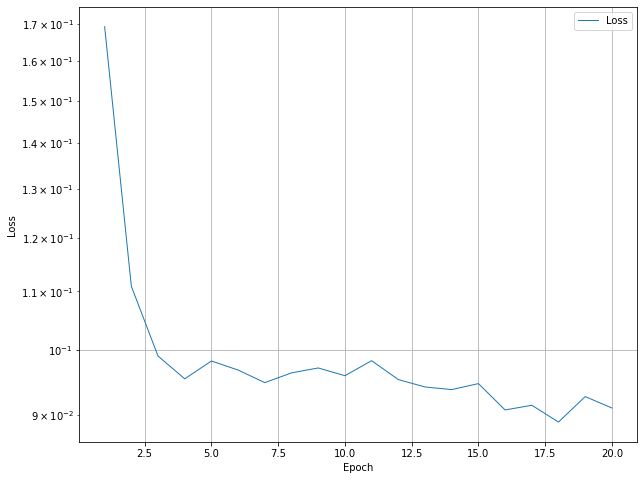

In [18]:
# Your answer goes here. ################################################
net_config['use_batchnorm'] = True
net_config["weight_decay"] = 0.
net_config["dropout_rate"] = .15
Net = create_net(config = net_config, activation = "ReLU")
start_time = time()
_ = evaluate(Net, X_train, y_train, X_val, y_val, X_test, y_test,
             20, batch_size, ClassNLLCriterion(), "Adam", {'label': "Loss"})
print("it took {} s".format(round(time() - start_time, 3)))

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

  0%|          | 0/20 [00:00<?, ?it/s]Available device is  cpu
Our model: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]         200,960
       BatchNorm1d-2                  [-1, 256]             512
            Linear-3                  [-1, 256]          65,792
           Dropout-4                  [-1, 256]               0
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
Total params: 269,834
Trainable params: 269,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.03
Estimated Total Size (MB): 1.04
----------------------------------------------------------------
None
100%|██████████| 20/20 [01:11<00:00,  3.56s/it]
Plotted Losses: 
Our model has accuracy = 

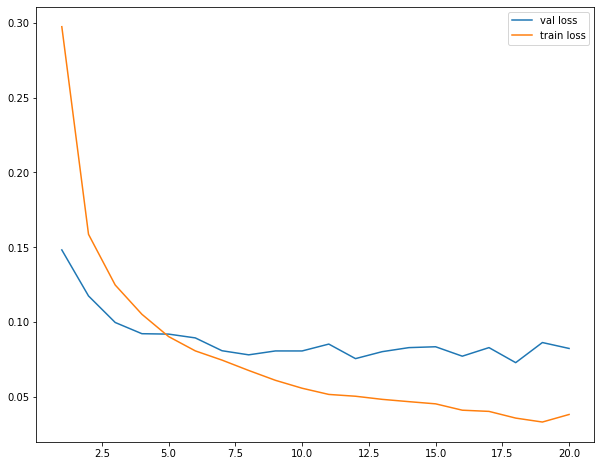

In [10]:
# Your beautiful code here.
import torch
import torch.nn as nn
from torchsummary import summary
from torch.optim import Adam

class Model(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, device,
                 n_layers: int, dropout_rate: int, n_classes: int):
        super(Model, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.device = device
        
        self.model = nn.Sequential()
        
        self.model.add_module("Initial", nn.Linear(self.input_dim, self.hidden_dim))
        prev_input_dim = self.hidden_dim       
        for layer in range(self.n_layers):
            self.model.add_module("BN", nn.BatchNorm1d(self.hidden_dim))
            self.model.add_module("Linear", nn.Linear(prev_input_dim, self.hidden_dim))
            self.model.add_module("Dropout", nn.Dropout(dropout_rate))
            
            self.model.add_module("RelU", nn.ReLU())
            prev_input_dim = self.hidden_dim
        self.model.add_module("Classifier", nn.Linear(prev_input_dim, self.n_classes))
        self.model.to(self.device)
        
    def forward(self, x): return self.model(x)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Available device is ", device)
model = Model(input_dim, hidden_dim = 256, device = device, 
              n_layers = 2, dropout_rate = .25, n_classes = n_classes)
print("Our model: ")
print(summary(model, (input_dim, )))
opt = Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
n_epochs = 20
batch_size = 128

val_history = []
train_history = []
val_accuracy = []


for epoch in tqdm(range(n_epochs), total = n_epochs):
    ep_train_loss_history = []
    ep_val_loss_history = []
    ep_val_accuracy = []
    _ = model.train()
            
    for X_batch, y_batch in get_batches((X_train, y_train), batch_size):
        opt.zero_grad()
        X_batch = torch.FloatTensor(X_batch).to(device)
        y_batch = torch.LongTensor(y_batch).to(device)        
        
        predictions = model(X_batch.view((-1, input_dim)))
        loss = loss_fn(predictions, y_batch)               
        loss.backward()
        opt.step()   
        ep_train_loss_history.append(loss.item())
        
    _ = model.eval()
    with torch.no_grad():
        for X_batch, y_batch in get_batches((X_val, y_val), batch_size):
            X_batch = torch.FloatTensor(X_batch).to(device)
            y_batch = torch.LongTensor(y_batch).to(device)        

            predictions = model(X_batch.view((-1, input_dim)))
            loss = loss_fn(predictions, y_batch)               
            ep_val_loss_history.append(loss.item())
            ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == torch.max(predictions, 1)[1].cpu().numpy()) \
                                   / len(y_batch.cpu().numpy()))

    val_accuracy.append(np.mean(ep_val_accuracy))
    val_history.append(np.mean(ep_val_loss_history))    
    train_history.append(np.mean(ep_train_loss_history))
    
print("Plotted Losses: ")    
plt.plot(np.arange(1, n_epochs + 1, 1), val_history, label = "val loss")
plt.plot(np.arange(1, n_epochs + 1, 1), train_history, label = "train loss")
plt.legend(loc = "best")

loss_history = []
accuracy = []
with torch.no_grad():
    _ = model.eval()

    for X_batch, y_batch in get_batches((X_test, y_test), batch_size):
        X_batch = torch.FloatTensor(X_batch).to(device)
        y_batch = torch.LongTensor(y_batch).to(device)        

        predictions = model(X_batch.view((-1, input_dim)))
        loss = loss_fn(predictions, y_batch)               
        loss_history.append(loss.item())
        accuracy.append(np.sum(y_batch.cpu().numpy() == torch.max(predictions, 1)[1].cpu().numpy()) \
                               / len(y_batch.cpu().numpy()))

print("Our model has accuracy = ", round(np.mean(accuracy), 3))